In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [5]:
from diffusers import DiffusionPipeline
from xformers.ops import MemoryEfficientAttentionFlashAttentionOp
import torch
from rembg import remove
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image


In [ ]:
pipe = DiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-xl-base-0.9", torch_dtype=torch.float16, use_safetensors=True, variant="fp16")

pipe.enable_xformers_memory_efficient_attention(attention_op=MemoryEfficientAttentionFlashAttentionOp)
pipe.vae.enable_xformers_memory_efficient_attention(attention_op=None)
pipe = pipe.to(0)

In [ ]:
refiner = DiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-xl-refiner-0.9", torch_dtype=torch.float16, use_safetensors=True, variant="fp16")

refiner.enable_xformers_memory_efficient_attention(attention_op=MemoryEfficientAttentionFlashAttentionOp)
refiner.vae.enable_xformers_memory_efficient_attention(attention_op=None)
refiner = refiner.to(0)   

In [ ]:
animals = ["bear", "horse", "deer", "elephant"]

In [ ]:
for animal in animals:
    save_path = os.path.join("pseudo_new", animal)
    os.makedirs(save_path, exist_ok=True)
    
    for i in range(200):
        prompt = f"a {animal} facing forwards. I want to see the whole body of the {animal}."
        
        image = pipe(prompt, output_type="latent").images[0]
        image = refiner(prompt=prompt, image=image).images[0]
        image = remove(image)
        
        image.save(os.path.join(save_path, f"{i}.png"))
        print(os.path.join(save_path, f"{i}.png"))

In [ ]:
plt.imshow(image)

In [ ]:
image = remove(image)
plt.imshow(image)

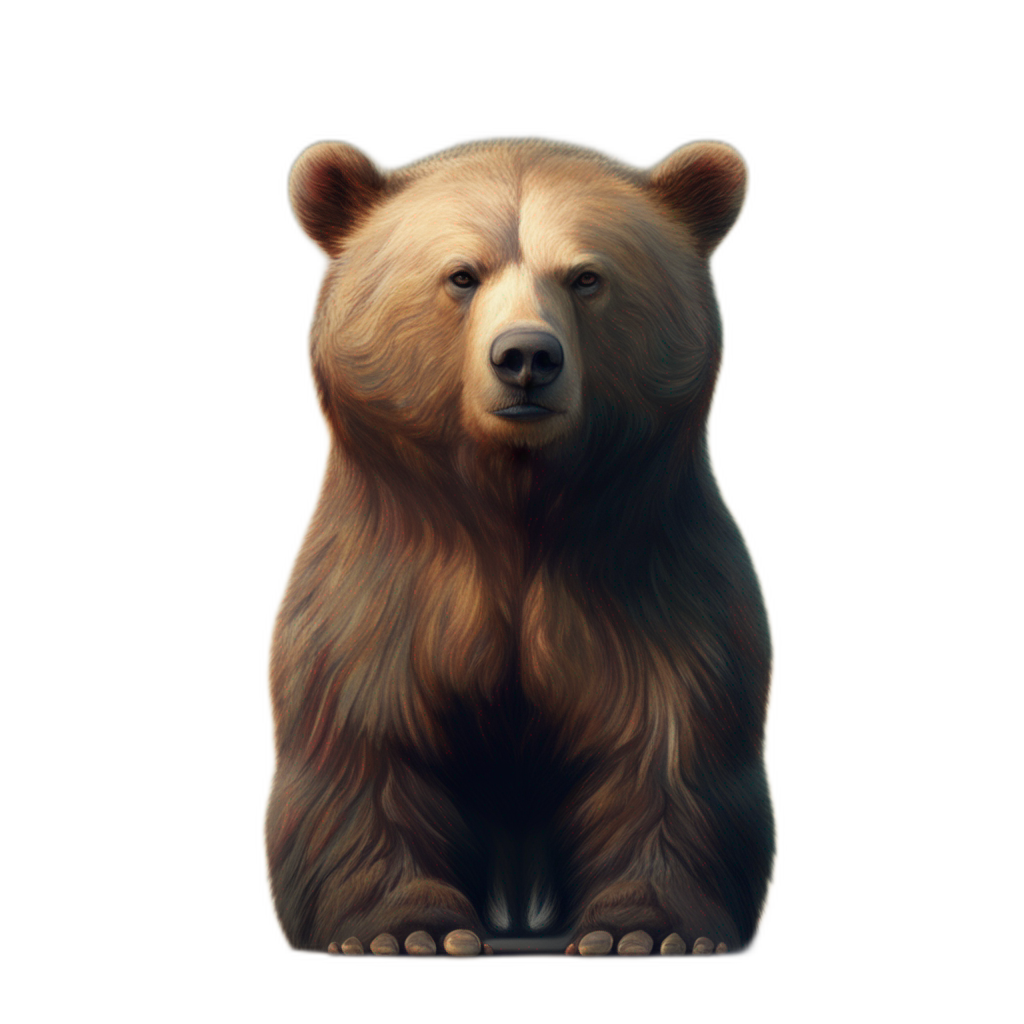

In [6]:
animal = Image.open("pseudo_new/bear/0.png")
animal


In [12]:
image_data = animal.getdata()

non_empty_pixels = False
x_min, y_min, x_max, y_max = 0, 0, 0, 0

for y in range(animal.height):
    for x in range(animal.width):
        r, g, b, a = animal.getpixel((x, y))
        if a > 0:
            if not non_empty_pixels:
                non_empty_pixels = True
                x_min, y_min = x, y
                x_max, y_max = x, y
            else:
                if x < x_min:
                    x_min = x
                if y < y_min:
                    y_min = y
                if x > x_max:
                    x_max = x
                if y > y_max:
                    y_max = y          

ci = animal.crop((x_min, y_min, x_max + 1, y_max + 1))

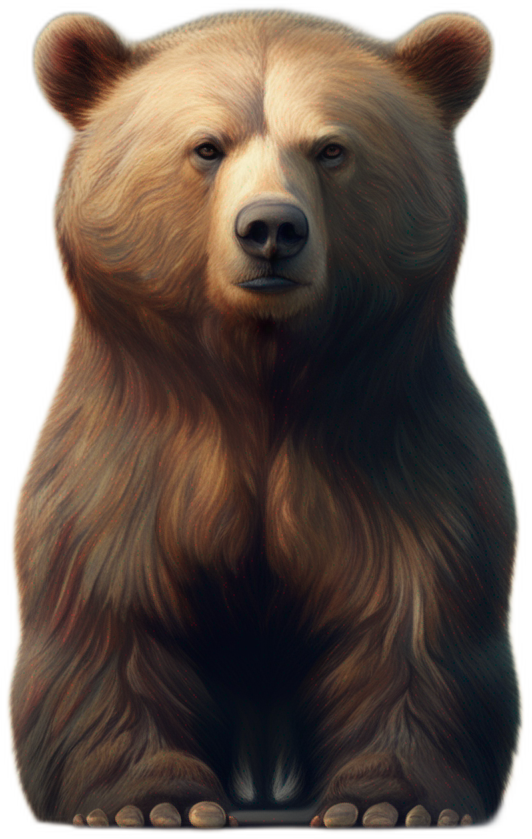

In [13]:
ci